In [1]:
import numpy as np
import torch.nn as nn
import torch as torch
import torch.optim as optim
import poly_fit as pf
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython import display 
import pylab as pl 
import time as time 

<h1>Introduciton</h1>
In this notebook, we use a known model or function, $R^1 \rightarrow R^1$. 
We stay in one dimension for ease of visualization. We can use $x$ axis for input and $y$ axis for output. Visualizing the behaviour of a known and well controlled model 
as well as the function that framework is trying to learn makes it easy to understand the issues with data, model complexity, overfitting etc. 
<h2>Target data </h2>
We use a linear and quadratic polynomial to generate target data for learning. 
<h3>Linear target</h3>
$a+bx$, default: $1+2x$

In [2]:
def linear(x, a=1.,b=2.):
    return a*x+b

<h3>Quadratic target</h3>
$a+bx+cx^2$, default: $4x^2-2x+1$

In [3]:
def quad(x, a=1., b=-2., c=4):
    return a-b*x+c*np.square(x)

<h2>Learned model</h2>
We use a custom pytorch layer that represents polynomial model of different degrees.  

<h1>Utilities and common functions</h1>
<h3>Plotting functions</h3>

In [4]:
def plot_and_compare(x,y, real_func,  net_func, xmin=0,xmax=5, ylim=None, save_file=None):
    x_net = np.arange(xmin, xmax, .1)
    y_tensor = net_func(x_net) 
    y_pred = y_tensor.data.numpy() 
    y_real = real_func(x_net)
    l1,=plt.plot(x_net, y_pred, 'r-o',markersize=1, label="Learned function")
    l2,=plt.plot(x_net, y_real, 'bo', markersize=1, label="Real function")
    l3,=plt.plot(x,y,'gx', label="Learning data")
    plt.legend(handles=[l1,l2,l3])
    if not (ylim is None):
        plt.ylim(ylim)
    if not (save_file is None):
        plt.savefig(save_file, dpi=150)

def plot_and_compare_animate(x,y, real_func,  net_func, xmin=0,xmax=5, ylim=None, show_arrows=False, pause_time=-1):
    x_net = np.arange(xmin, xmax, .1)
    y_tensor = net_func(x_net) 
    y_pred = y_tensor.data.numpy() 
    y_real = real_func(x_net)
    plt.clf() 
    if not (ylim is None):
        plt.ylim(ylim)
    l1,=plt.plot(x_net, y_pred, 'r-o',markersize=1, label="Learned function")
    l2,=plt.plot(x_net, y_real, 'bo', markersize=1, label="Real function")
    l3,=plt.plot(x,y,'gx', label="Learning data")
    if show_arrows:
        y_begin = net_func(x).data.numpy() 
        abs_dely = y -y_begin
        for i, xi in enumerate(x):
            dx, dy = 0, abs_dely[i] 
            plt.arrow(x[i], y_begin[i],dx, dy )
    plt.legend(handles=[l1,l2,l3])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    if pause_time>0:
        time.sleep(pause_time)
    
plt.rcParams['figure.figsize'] = [12, 8]

<h1>Fitting linear data to linear model</h1>
Generating only 4 data points. 

In [5]:
x = np.array([1.,2.,3,4])
y = linear(x)
y_t = torch.from_numpy( y )

Creating a  polynomial $a_0+a_1x$

In [6]:
net = pf.PolynomialLayer(2) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss() 

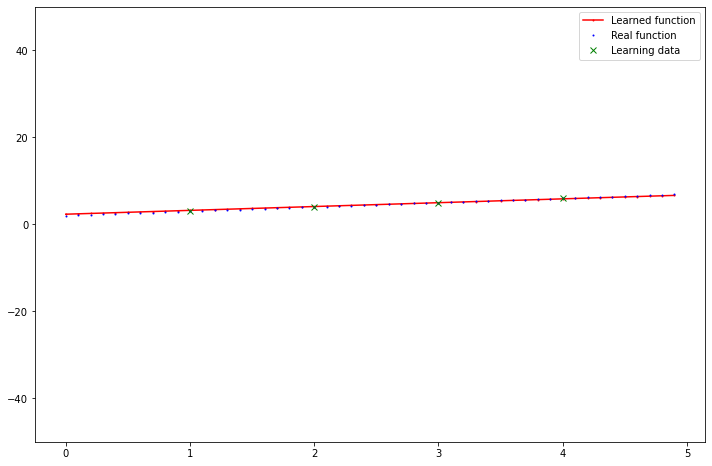

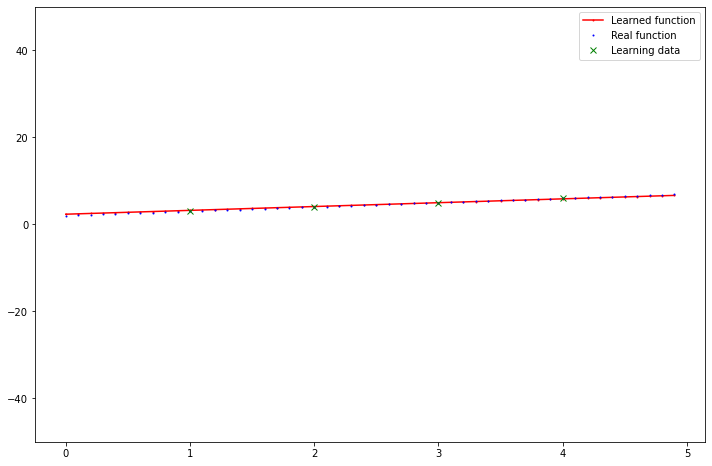

In [7]:
for i in range(1000):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    loss.backward()
    optimizer.step()
    if i%100 == 0 :
        print(loss)
        plot_and_compare_animate(x,y,linear,  net, ylim=(-50,50), show_arrows=True, pause_time=.1)
        #net.print_weights()

Parameter containing:
tensor([[2.3071, 0.8924]], requires_grad=True)


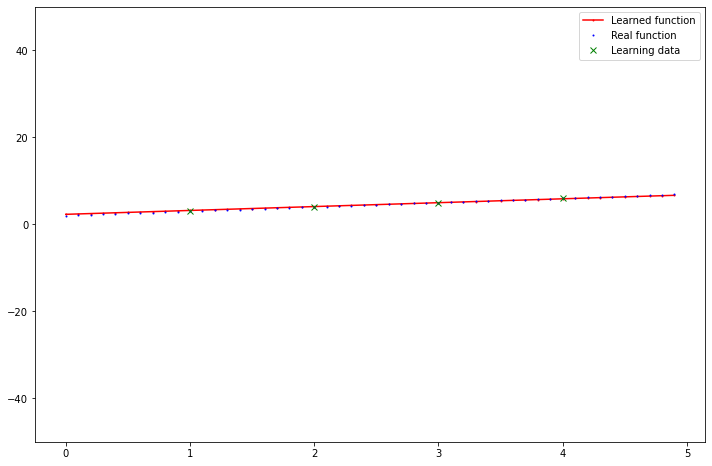

In [8]:
plot_and_compare(x,y,linear,  net, ylim=(-50,50), save_file='linear_eg1.png')
net.print_weights() 

<h1>Fitting linear data to higher order polynomial</h1>
Let us create data first 

In [9]:
x = np.array([1.,2.,3,4])
y = linear(x)
y_t = torch.from_numpy( y )

Here, the function is $a_0+a_1x+a_2x^2+\dots +a_9x^9$ and we need to find the values of 
$a_0, a_1, \dots a_9$. You should expect this function to be rather "wavy" - in general, a polynomial of digree $n$ will have a total of $n$ 
real and imaginary roots. 

In [10]:
net = pf.PolynomialLayer(10) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss() 

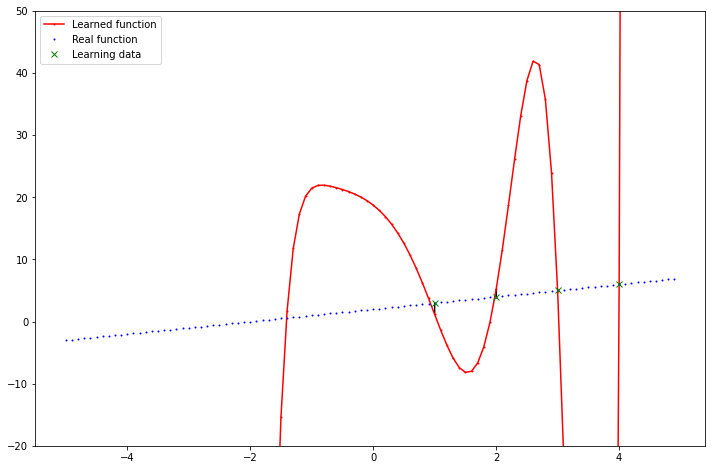

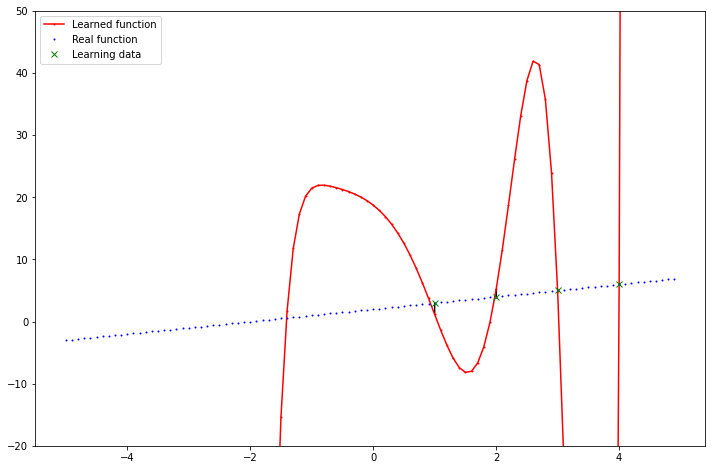

In [11]:
for i in range(100000):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    loss.backward()
    optimizer.step()
    if i%1000 == 0 :
        ylim=(-20,50)
        plot_and_compare_animate(x,y,linear,  net, -5,5, ylim=ylim, show_arrows=True)
        #net.print_weights()

Parameter containing:
tensor([[18.8214, -7.7807, -7.2586, -3.5361, -0.4048, -0.4718,  1.2292,  1.4669,
         -1.0213,  0.1480]], requires_grad=True)


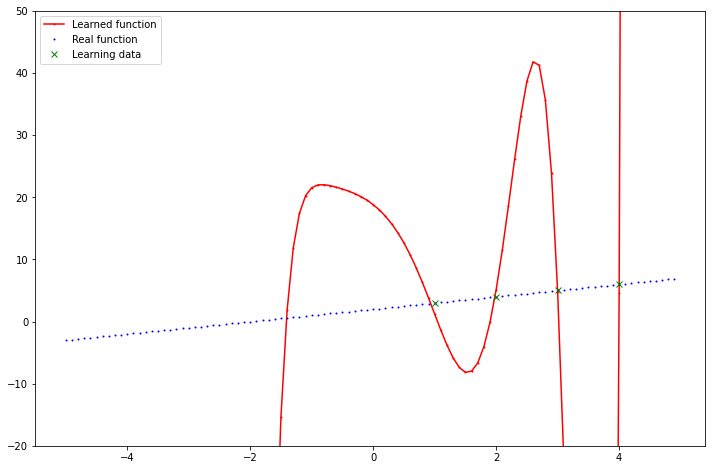

In [12]:
ylim=(-20,50)
plot_and_compare(x,y,linear,  net, -5,5, ylim=ylim, save_file="linear_w_degree_9.png")
net.print_weights() 

<h1>Using only two data points!</h1>

In [13]:
x = np.array([-4,4])
y = linear(x)
y_t = torch.from_numpy( y )

In [14]:
net = pf.PolynomialLayer(10) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss() 

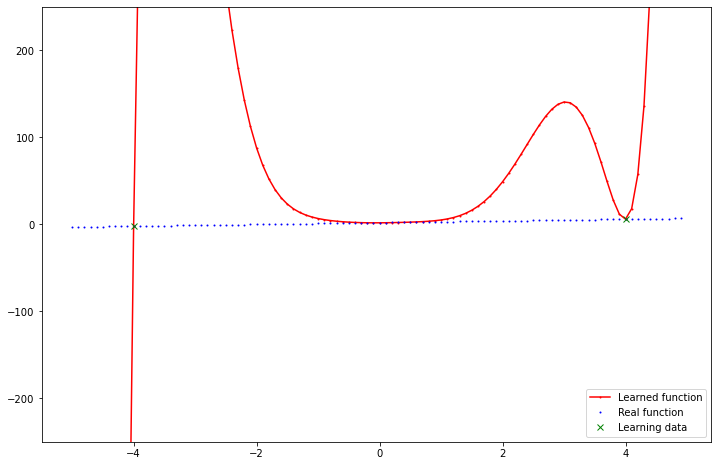

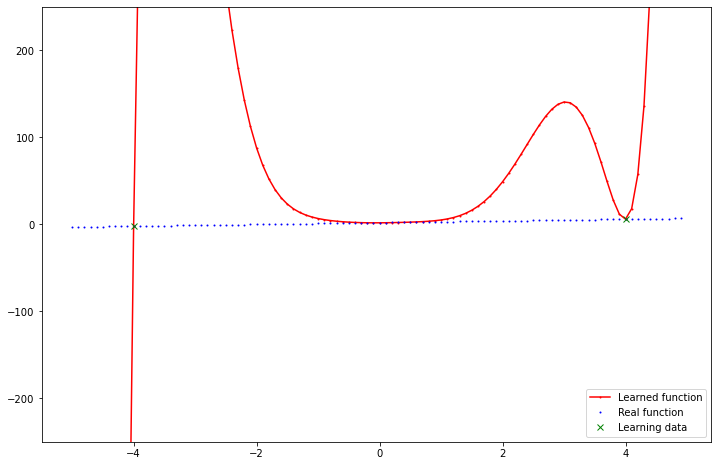

In [16]:
for i in range(10000):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    loss.backward()
    optimizer.step()
    if i%1000 == 0 :
        ylim=(-250,250)
        plot_and_compare_animate(x,y,linear,  net, -5,5, ylim=ylim, show_arrows=True)
        #net.print_weights()

Parameter containing:
tensor([[ 1.7791,  0.4738,  2.9804, -2.1361,  0.0593,  1.2326,  1.1249, -0.4224,
         -0.0713,  0.0221]], requires_grad=True)


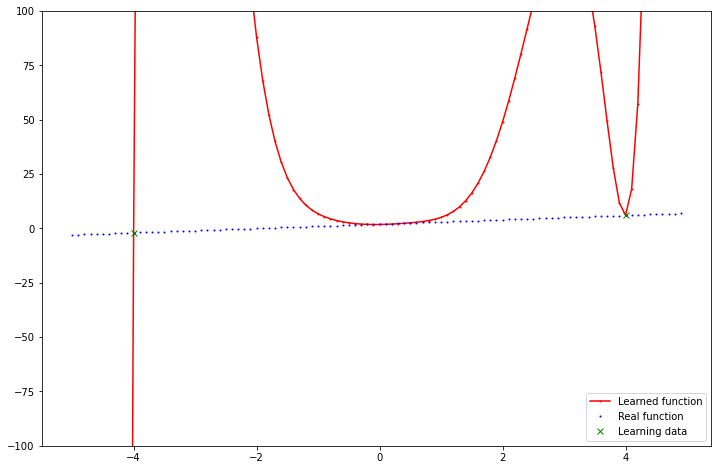

In [17]:
ylim=(-100,100)
plot_and_compare(x,y,linear,  net, -5,5, ylim=ylim, save_file='linear_w_degree_9_2points_only.png')
net.print_weights() 

<h1>Fitting data generated from a quadtratic model</h1>
<h2>First we fit to a quadratic model</h2>
Look at

  ```python
    net = pf.PolynomialLayer(3) 
  ```
which creates a polynomial of digree 2 for fitting the model 

In [18]:
x = np.array([-4.,4, 2])
y = quad(x)
y_t = torch.from_numpy( y )
net = pf.PolynomialLayer(3) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss()

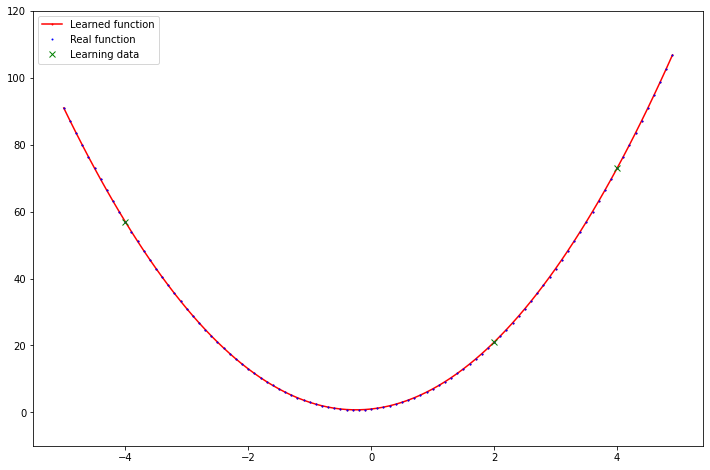

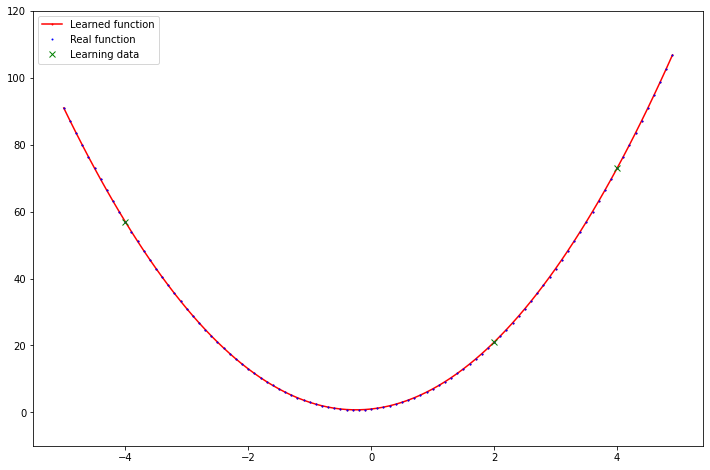

In [19]:
losses=[] 
each_n = 1000
for i in range(10000):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    losses.append(loss) 
    loss.backward()
    optimizer.step()
    if i%each_n == 0 :
        loss_n = losses[each_n:]
        if loss_n:
            #print(torch.mean(torch.Tensor(loss_n)).data)
            ylim=(-10,120)
            plot_and_compare_animate(x,y,quad,  net, -5,5, ylim=ylim, show_arrows=True)
        #net.print_weights()

Parameter containing:
tensor([[1.0000, 2.0000, 4.0000]], requires_grad=True)


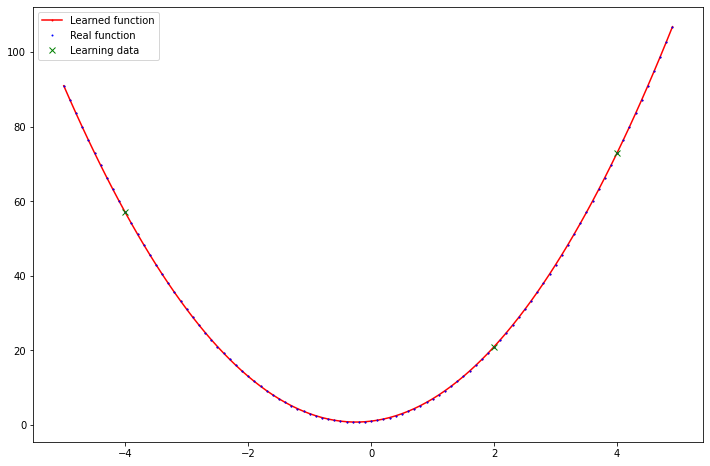

In [20]:
plot_and_compare(x,y,quad,  net, -5,5, save_file='quad_w_degree_2.png')
net.print_weights() 

<h1>Fitting a 9 degree polynomial to quadratic data</h1>

In [21]:
x = np.array([-4.,4, 2])
y = quad(x)
y_t = torch.from_numpy( y )
net = pf.PolynomialLayer(10) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss()

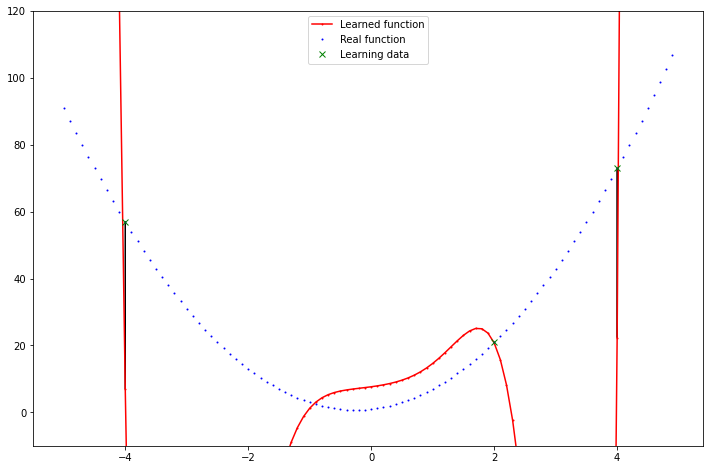

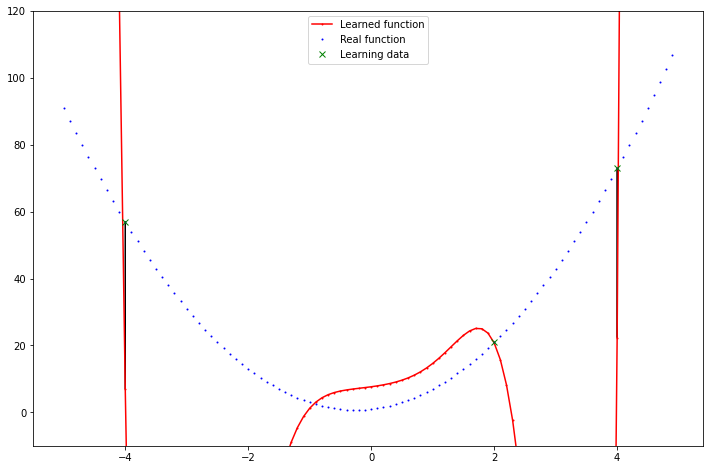

In [23]:
losses=[] 
each_n = 1000
for i in range(each_n*10):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    losses.append(loss) 
    loss.backward()
    optimizer.step()
    if i%each_n == 0 :
        loss_n = losses[each_n:]
        if loss_n:
            #print(torch.mean(torch.Tensor(loss_n)).data)
            plot_and_compare_animate(x,y,quad,  net, -5,5,ylim=ylim, show_arrows=True) #'quad_w_degree_9_5points.png')
        #net.print_weights()

Parameter containing:
tensor([[ 7.6477,  2.5011,  1.5970,  2.4571, -0.6042,  2.0748, -0.7566, -0.3581,
          0.0501,  0.0137]], requires_grad=True)


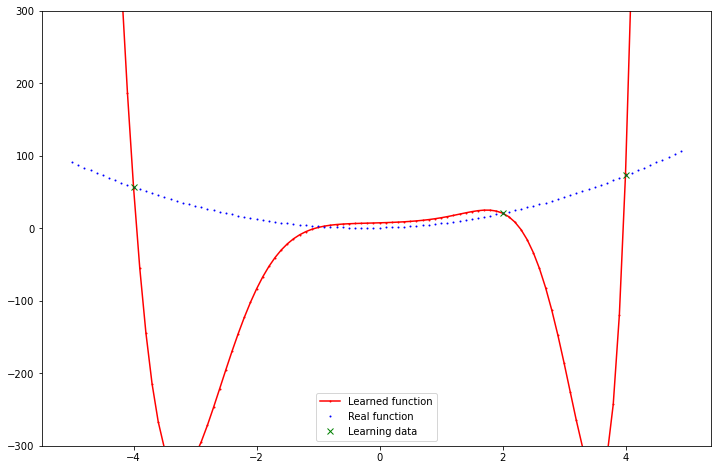

In [24]:
ylim=(-300,300)
plot_and_compare(x,y,quad,  net, -5,5,ylim=ylim, save_file='quad_w_degree_9.png')
net.print_weights() 

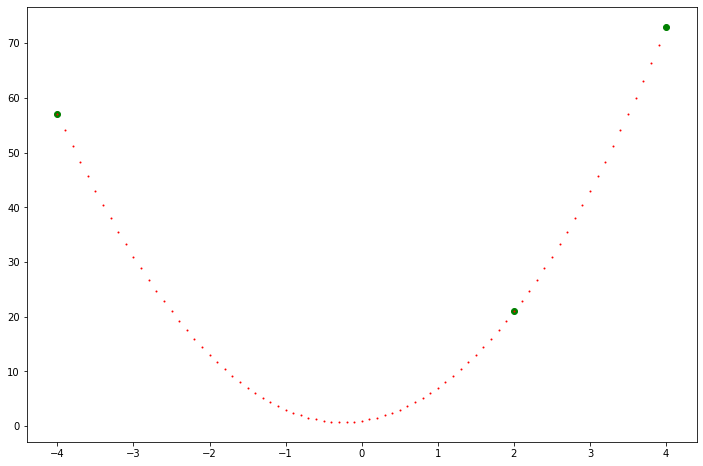

In [25]:
plt.plot(x,y,'go')
plt.plot(np.arange(-4,4,.1), quad(np.arange(-4,4,.1)), 'ro',markersize=1)

<h2>More points</h2>

In [26]:
x = np.array([-4.,-3,-2,-1,0,1,2,3,4])
y = quad(x)
y_t = torch.from_numpy( y )
net = pf.PolynomialLayer(10) 
optimizer = optim.Adam(net.parameters(), lr=.01)
loss_func = nn.MSELoss()

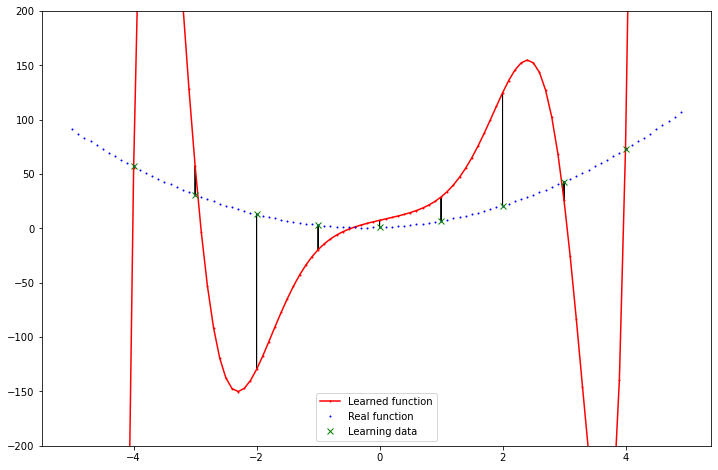

In [ ]:
losses=[] 
each_n = 1000
for i in range(each_n*50):
    optimizer.zero_grad()
    y_pred  = net(x)
    loss = loss_func(y_pred, y_t)
    losses.append(loss) 
    loss.backward()
    optimizer.step()
    if i%each_n == 0 :
        loss_n = losses[each_n:]
        if loss_n:
            #print(torch.mean(torch.Tensor(loss_n)).data)
            ylim=(-200,200)
            plot_and_compare_animate(x,y,quad,  net, -5,5,ylim=ylim, show_arrows=True) #'quad_w_degree_9_5points.png')

In [ ]:
ylim=(-100,100)
plot_and_compare(x,y,quad,  net, -5,5,ylim=ylim,  save_file='quad_w_degree_9_5points.png')
net.print_weights() 